In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import re

# EDA

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Access a specific folder in your Google Drive
path = "/content/drive/MyDrive/Dataset/Twitter_Data.csv"
# Load dataset
data = pd.read_csv(path)

In [7]:
data.head

<bound method NDFrame.head of                                                clean_text  category
0       when modi promised “minimum government maximum...      -1.0
1       talk all the nonsense and continue all the dra...       0.0
2       what did just say vote for modi  welcome bjp t...       1.0
3       asking his supporters prefix chowkidar their n...       1.0
4       answer who among these the most powerful world...       1.0
...                                                   ...       ...
162975  why these 456 crores paid neerav modi not reco...      -1.0
162976  dear rss terrorist payal gawar what about modi...      -1.0
162977  did you cover her interaction forum where she ...       0.0
162978  there big project came into india modi dream p...       0.0
162979  have you ever listen about like gurukul where ...       1.0

[162980 rows x 2 columns]>

In [28]:
data.isnull().sum()

clean_text    0
category      7
compound      0
sentiment     0
dtype: int64

In [29]:
# Remove rows with NaN values
data = data.dropna(subset=['clean_text', 'category'])

# Preprocessing

In [16]:
def clean_text(text):
    # Convert to string if not already
    text = str(text)

    # Remove URLs using regular expressions
    text = re.sub(r'http\S+', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z]+', ' ', text)

    # Convert text to lowercase
    text = text.lower()

    return text


In [30]:
data['clean_text'] = data['clean_text'].apply(clean_text)

<ipython-input-30-44b06e546773>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['clean_text'] = data['clean_text'].apply(clean_text)


In [31]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

#Model Building and Training

Valence Aware Dictionary and sEntiment Reasoner), a lexicon and rule-based tool for sentiment analysis

In [32]:
# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

Calculate the sentiment compound score for each cleaned text using VADER. The compound score represents the overall sentiment of the text.

In [33]:
# Assign sentiment scores to the data
data['compound'] = data['clean_text'].apply(lambda x: sid.polarity_scores(x)['compound'])

<ipython-input-33-dc540bd51f35>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['compound'] = data['clean_text'].apply(lambda x: sid.polarity_scores(x)['compound'])


Map the compound scores to sentiment labels. If the compound score is less than -0.1, the sentiment is labeled as -1 (negative); if it's greater than 0.1, the sentiment is labeled as 1 (positive); otherwise, it's labeled as 0 (neutral).

In [34]:
# Map compound scores to sentiment labels
data['sentiment'] = data['compound'].apply(lambda x: -1 if x < -0.1 else (1 if x > 0.1 else 0))

<ipython-input-34-2e46fb047a54>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'] = data['compound'].apply(lambda x: -1 if x < -0.1 else (1 if x > 0.1 else 0))


Define the features (X) as the cleaned text data and the target variable (y) as 'category', assuming 'category' contains values -1, 0, and 1.

In [35]:
X = data['clean_text']
y = data['category']

Initialize a TF-IDF vectorizer with a maximum of 5000 features and stop words removed. It then transforms the cleaned text data (X) into TF-IDF feature vectors (X_tfidf).

In [36]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(X)

Split the dataset into training and testing sets using a 80-20 split ratio. The random_state ensures reproducibility.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

Initialize a Logistic Regression model and fit it to the training data.

In [38]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Make predictions on the test data using the trained Logistic Regression model.

In [40]:
y_pred = model.predict(X_test)

# Model Evaluation

In [41]:
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [42]:
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)

Accuracy: 0.853382420616659
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.87      0.75      0.80      7230
         0.0       0.80      0.96      0.87     10961
         1.0       0.90      0.83      0.86     14404

    accuracy                           0.85     32595
   macro avg       0.86      0.84      0.85     32595
weighted avg       0.86      0.85      0.85     32595



A bar chart to visualize the distribution of sentiments (positive, neutral, and negative) in the Twitter data.

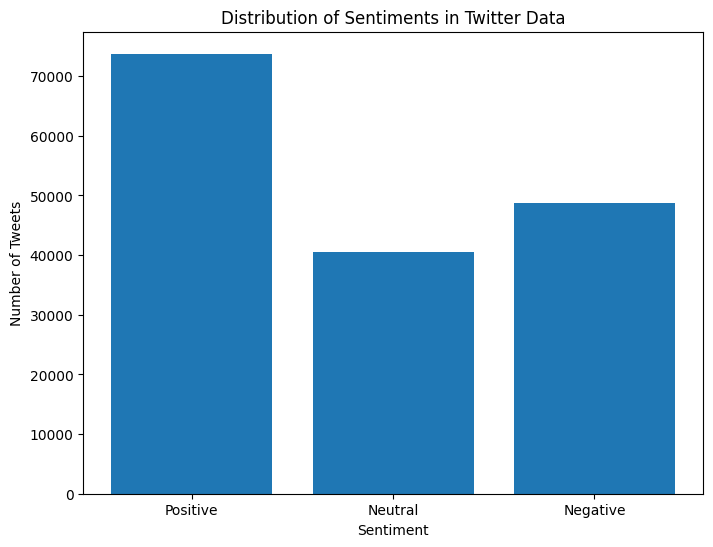

In [43]:
positive_tweets = data[data['sentiment'] == 1]
neutral_tweets = data[data['sentiment'] == 0]
negative_tweets = data[data['sentiment'] == -1]

plt.figure(figsize=(8, 6))
plt.bar(['Positive', 'Neutral', 'Negative'], [len(positive_tweets), len(neutral_tweets), len(negative_tweets)])
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Sentiments in Twitter Data')
plt.show()